In [1]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_size = 10000
test_size = 3000

In [3]:
train = glob.glob("C:/Users/kaust/OneDrive/Desktop/chess/dataset/train/*.jpeg")
test = glob.glob("C:/Users/kaust/OneDrive/Desktop/chess/dataset/test/*.jpeg")

In [4]:
shuffle(train)
shuffle(test)

In [5]:
train = train[:train_size]
test = test[:test_size]

In [6]:
piece_symbols = 'prbnkqPRBNKQ'

In [7]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

In [8]:
print(fen_from_filename(train[0]))

8-5P2-8-1P6-8-K4n2-5k2-8


In [9]:
print(fen_from_filename(train[100]))

N7-Bp1P2n1-8-8-K5q1-5p2-8-7k


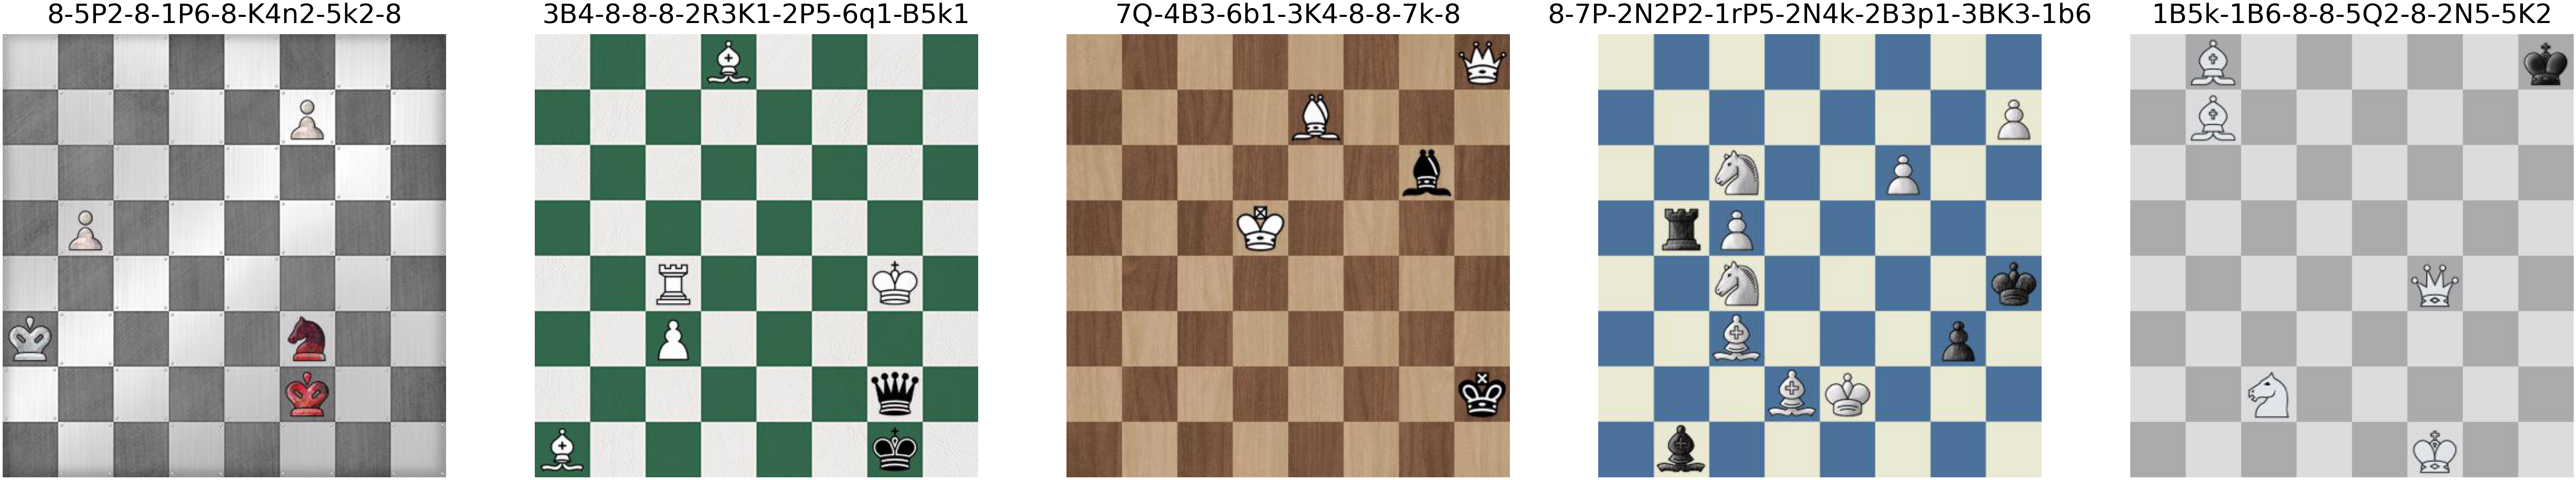

In [10]:
f, axarr = plt.subplots(1,5, figsize=(120, 120))

for i in range(0,5):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

In [11]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

# processing image


In [12]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [13]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

In [14]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

10000/10000 [==============================] - 580s 58ms/step - loss: 0.0203 - accuracy: 0.9948


In [16]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [17]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99967%


In [18]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

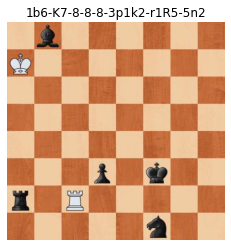

In [19]:
display_with_predicted_fen(test[2])